In [1]:
import sys
import os

import numpy as np
import datetime  

"""import Tkinter,tkFileDialog

from Tkinter import *
import ttk
"""
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_meinhold')
sys.path.append('../utils_meinhold')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca')
sys.path.append('../utils_zonca')
#sys.path.append('D:\\software_git_repos\\cofe-python-analysis-tools\\utils_zonca\\pointing')
sys.path.append('../utils_zonca/pointing')
#sys.path.append('D:\\software_git_repos\\greenpol')
sys.path.append('../')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\')
sys.path.append('../telescope_control')
#sys.path.append('D:\\software_git_repos\\greenpol\\telescope_control\\VtoT\\')
sys.path.append('../VtoT')
import realtime_gp as rt
import h5py

#from functions import *

import cPickle
from scipy.signal import savgol_filter
from scipy import signal, stats

import numpy.ma as ma

from scipy import interpolate
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

/home/labuser/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#%matplotlib inline

In [3]:
def plotnow_azelsig(data, az, el, chan, var, res, xmin=0., xmax=360., ymin=-90., ymax=90., minmax=None, radec=False, supply_index=False, return_map=False):
    # flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    # fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    # i=0
    # while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    # pp=get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    # dd=get_all_demodulated_data(fld_demod, fld)
    # combined=combine_cofe_h5_pointing(dd,pp)

    # synchronized data az and el values
    az1, el1 = az * 1, el * 1
    data = data * 1

    # convert to temp for cryo sensors
    if chan == 12:
        data = convert.convert(data, 'i')
    if chan == 13:
        data = convert.convert(data, 'e')
    if chan == 14:
        data = convert.convert(data, 'h')
    if chan == 15:
        data = convert.convert(data, 'l')

    steps = len(data)

    # set az/el resolution
    dx = res
    dy = res

    # set up bins/grid
    if radec:
        x, y = np.arange(xmin, xmax + dx, dx), np.arange(ymin, ymax + dy, dy)
    else:
        if ymin < 0.:
            ymin == 0.
        x, y = np.arange(xmin, xmax + dx, dx), np.arange(ymin, ymax + dy, dy)
    AZ, EL = np.meshgrid(x, y)

    # small number for comparing floats
    #epsilon = 1e-6

    # set up matrix for signal
    z1 = np.zeros(len(x) * len(y))
    sig = np.reshape(z1, (len(y), len(x)))

    # set up matrix for keeping track of data points in single bin for averaging
    z2 = np.zeros(len(x) * len(y))
    count = np.reshape(z2, (len(y), len(x)))
    
    for i in range(steps):
        # round az/el points for comparison with grid
        el1[i] = rt.round_fraction(el1[i], dy)
        az1[i] = rt.round_fraction(az1[i], dx)
        
        
        # find where data points belong in grid
        #iel = np.where(abs(y - el1[i]) < epsilon)[0][0]
        iel = np.where(abs(y - el1[i]) == abs(y - el1[i]).min())[0][0]
        #print iel
        iaz = np.where(abs(x - az1[i]) == abs(x - az1[i]).min())[0][0]

        # add 1 each time data point lands in same bin
        count[iel][iaz] += 1

        # add total number of data values in bin
        sig[iel][iaz] = sig[iel][iaz] + data[i]

        # mask 0 count values so they dont show up in color plot
    count = ma.masked_where(count == 0.0, count)

    # take average of all data points in single bin
    sig = sig / count

    try:
        # change units on plot label
        if int(chan[2:]) < 12:
            unit = 'V'
        else:
            unit = 'K'

        name = rt.chantoname(chan)
    except:
        unit = 'C'
        name = chan

    if return_map:
        return AZ, EL, sig
    else:
        plt.pcolormesh(AZ, EL, sig, cmap='jet')
        plt.colorbar(label='Signal, %s' % unit)
        if minmax != None:
            plt.clim(minmax[0], minmax[1])
        else:
            plt.clim(data.min(), data.max())
        if radec == False:
            plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
            plt.ylabel('elevation (deg)')
            plt.xlabel('azimuth (deg)')
        else:
            plt.axis([0., 360., -90, 90.])
            plt.xlabel('ra (deg)')
            plt.ylabel('dec (deg)')
        plt.title('%s %s data binned to azimuth and elevation' % (name, var))
        plt.grid()
        plt.show()

In [4]:
f = "../../polaris_data/demod_data/H1DC_Moon.h5"
data=h5py.File(f)['data']

In [5]:
gain = -4.11

In [6]:
Tdata = data['TEMP']
ra = np.degrees(data['PHI'])
dec = np.degrees(np.pi/2. - data['THETA'])

phi = data['PHI']
theta = data['THETA']

In [7]:
chan='H1HiDC'

In [8]:
'''var = 'T'
RA, DEC, sig = plotnow_azelsig(Tdata, ra, dec, rt.nametochan(chan), var, 0.1, minmax=None, radec=True, return_map=True, masked=False)'''

"var = 'T'\nRA, DEC, sig = plotnow_azelsig(Tdata, ra, dec, rt.nametochan(chan), var, 0.1, minmax=None, radec=True, return_map=True, masked=False)"

In [9]:
'''plt.figure()
plt.pcolormesh(RA, DEC, sig, cmap='jet')
plt.colorbar(label = 'Signal, V')
vmax = -0.2*gain
vmin = 0.0
plt.clim(vmin,vmax)
radec=True
if radec == False:
    plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
    plt.ylabel('elevation (deg)')
    plt.xlabel('azimuth (deg)')
else:
    plt.axis([0., 360., -90, 90.])
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
plt.title('%s %s removed binned az mean' % (chan, var))
plt.grid()
plt.show()'''

"plt.figure()\nplt.pcolormesh(RA, DEC, sig, cmap='jet')\nplt.colorbar(label = 'Signal, V')\nvmax = -0.2*gain\nvmin = 0.0\nplt.clim(vmin,vmax)\nradec=True\nif radec == False:\n    plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])\n    plt.ylabel('elevation (deg)')\n    plt.xlabel('azimuth (deg)')\nelse:\n    plt.axis([0., 360., -90, 90.])\n    plt.xlabel('ra (deg)')\n    plt.ylabel('dec (deg)')\nplt.title('%s %s removed binned az mean' % (chan, var))\nplt.grid()\nplt.show()"

In [10]:
ramin = 64.7
ramax = 67.17
decmin = 14.72
decmax = 17.61

data_crab = Tdata[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)]
ra_crab = ra[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)]
dec_crab = dec[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)]

In [11]:
dx, dy = 0.1, 0.1
x, y = np.arange(ramin, ramax + dx, dx), np.arange(decmin, decmax + dy, dy)

In [12]:
yarray = np.arange(len(y))
decarray = np.linspace(0, len(y), len(dec_crab))
yinterp = np.interp(decarray, yarray, y)

In [13]:
plt.figure()

#plt.plot(y, label='y')
plt.plot(dec_crab, label='dec')
plt.legend()

In [14]:
plt.figure()
plt.plot(ra_crab)

In [15]:
var = 'T'
RA, DEC, sig = plotnow_azelsig(data_crab, ra_crab, dec_crab, rt.nametochan(chan), var, res=0.1, xmin=ramin-2, xmax=ramax+2, ymin = decmin-2, ymax=decmax+2, minmax=None, radec=True, return_map=True)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in divide


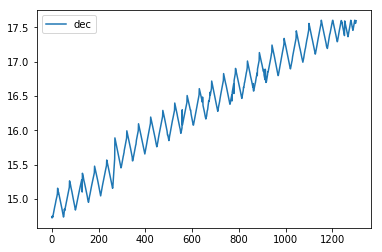

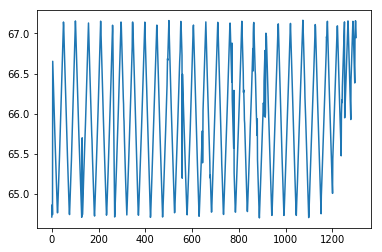

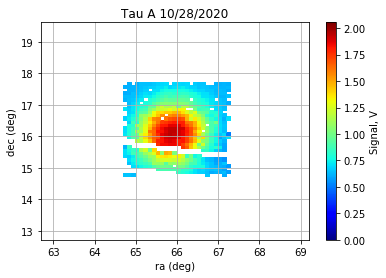

In [16]:
plt.figure()
plt.pcolormesh(RA, DEC, sig, cmap='jet')
plt.colorbar(label = 'Signal, V')
vmax = -0.5*gain
vmin = 0.0
plt.clim(vmin,vmax)
radec=True
#plt.axis([0., 360., -90, 90.])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Tau A 10/28/2020')
plt.grid()
plt.show()

In [17]:
dmax = data_crab.max()
ramax = ra_crab[data_crab == dmax][0]
decmax = dec_crab[data_crab == dmax][0]
print ramax, decmax

65.91614269157269 16.183927916130234


In [18]:
res = 0.1
dra = data_crab[abs(dec_crab - decmax) <= res]
raline = ra_crab[abs(dec_crab - decmax) <= res]

ddec = data_crab[abs(ra_crab - ramax) <= res]
decline = dec_crab[abs(ra_crab - ramax) <= res]

rasort = np.argsort(raline)
dra = dra[rasort]
raline = raline[rasort]

decsort = np.argsort(decline)
ddec = ddec[decsort]
decline = decline[decsort]

In [19]:
plt.figure()
plt.plot(decline, ddec, 'k-')
plt.title('Tau A profile along Dec')
plt.xlabel('Dec (deg)')
plt.ylabel('Signal (K)')
plt.grid()

In [20]:
plt.figure()
plt.plot(raline, dra, 'k-')
plt.title('Tau A profile along ra')
plt.xlabel('ra (deg)')
plt.ylabel('Signal (K)')
plt.grid()

In [21]:
def func(ra, o, A, mu, sig):
    return o + A*np.exp(-(ra-mu)**2 / 2 / sig**2)

In [22]:
rapopt, rapcov = curve_fit(func, raline, dra ,p0=[0.5, 1.5, 65.8, 1.0])
raoffset, raamplitude, ramean, rastd = rapopt
rafwhm = 2*rastd*np.sqrt(2*np.log(2))
raerr = np.sqrt(np.diag(rapcov))
rafwhmerr = raerr[-1]

print 'RA profile:'
print 'offset: %.2f K' % raoffset
print 'Amplitude: %.2f K' % raamplitude
print 'True Signal Amplitude: %.2f K' % (raamplitude - raoffset)
print 'Mean: %.2f K' % ramean
print 'Standar Deviation: %.2f K' % rastd
print 'FWHM: %.2f +/- %.2f deg' % (rafwhm, rafwhmerr)
print '-------------------------'

decpopt, decpcov = curve_fit(func, decline, ddec ,p0=[0.6, 1.8, 16., 1.0])
decoffset, decamplitude, decmean, decstd = decpopt
decfwhm = 2*decstd*np.sqrt(2*np.log(2))
decerr = np.sqrt(np.diag(decpcov))
decfwhmerr = decerr[-1]

print 'DEC profile'
print 'offset: %.2f K' % decoffset
print 'Amplitude: %.2f K' % decamplitude
print 'True Signal Amplitude: %.2f K' % (decamplitude - decoffset)
print 'Mean: %.2f K' % decmean
print 'Standar Deviation: %.2f K' % decstd
print 'FWHM: %.2f +/- %.2f deg' % (decfwhm, decfwhmerr)
print '-------------------------'
print 'Avg Signal Amplitude: %.2f K' % (((decamplitude - decoffset)+(raamplitude - raoffset))/2.)

RA profile:
offset: 0.34 K
Amplitude: 1.63 K
True Signal Amplitude: 1.29 K
Mean: 65.87 K
Standar Deviation: 0.65 K
FWHM: 1.53 +/- 0.04 deg
-------------------------
DEC profile
offset: 0.64 K
Amplitude: 1.33 K
True Signal Amplitude: 0.69 K
Mean: 16.05 K
Standar Deviation: 0.63 K
FWHM: 1.49 +/- 0.03 deg
-------------------------
Avg Signal Amplitude: 0.99 K


In [23]:
measured_tau_ra = func(raline, *rapopt)- raoffset
measured_tau_dec = func(decline, *decpopt)- decoffset

In [24]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(raline, dra-raoffset, 'b--', linewidth=2, label='Tau A Signal')
plt.plot(raline, measured_tau_ra, 'k-', linewidth=2, label='gaussian fit FWHM = %.2f$^\circ$ $\pm$ %.2f$^\circ$' % (rafwhm, rafwhmerr))
plt.title('Tau A profile along RA')
plt.xlabel('RA (deg)')
plt.ylabel('Signal (K)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(decline, ddec-decoffset, 'r--', linewidth=2, label='Tau A Signal')
plt.plot(decline, measured_tau_dec, 'k-', linewidth=2, label='gaussian fit FWHM = %.2f$^\circ$ $\pm$ %.2f$^\circ$' % (decfwhm, decfwhmerr))
plt.title('Tau A profile along Dec')
plt.xlabel('Dec (deg)')
plt.ylabel('Signal (K)')
plt.legend()
plt.grid()

In [25]:
#make a tau A profile in RA
tau_fwhm = 0.533
tau_std = tau_fwhm/2./np.sqrt(2*np.log(2))
dtau = func(raline, 0., raamplitude, ramean, tau_std)
#dtau = dtau/dtau.sum()


#guess at beam size and make profile
beam_fwhm = 1.3
beam_std = beam_fwhm/2./np.sqrt(2*np.log(2))
dbeam = func(raline, 0., raamplitude, ramean, beam_std)

delta = np.zeros(len(measured_tau_ra))
imax = np.where(measured_tau_ra==measured_tau_ra.max())[0]
delta[imax]=1.

tau_norm = measured_tau_ra/measured_tau_ra.sum() 


dconvolved = np.convolve(dtau, dbeam, 'same')
#dconvolved[-5:] = dconvolved[-6]

#dconvolved = dconvolved - (dconvolved.min()-dtau.min())
#dconvolved = dconvolved*dtau.max()/dconvolved.max()

In [26]:
popt, cov = curve_fit(func, raline, dconvolved ,p0=[0.5, 1.5, 65.8, 1.0])
offset, amplitude, mean, std = popt
fwhm = 2*std*np.sqrt(2*np.log(2))
convolved_fit = (func(raline, offset, amplitude, ramean, std) - offset)*raamplitude/amplitude

In [27]:
plt.figure()
plt.plot(raline, dtau, linewidth=2, label='Theoretical Tau A Profile, FHWM = %.2f$^{\circ}$' % tau_fwhm)
plt.plot(raline, dbeam, linewidth=2, label='Guessed Beam Profile, FHWM = %.2f$^{\circ}$' % beam_fwhm)
#plot(raline, (dconvolved-offset)*raamplitude/amp, linewidth=2, label='Tau A convolved with %.2f$^{\circ}$ beam' % beam_fwhm)
#plot(raline, delta, linewidth=2, label='delta fcn')
plt.plot(raline, convolved_fit, 'k--', linewidth=2, label='Tau A convolved with %.2f$^{\circ}$ beam, FHWM = %.2f$^{\circ}$' % (beam_fwhm, fwhm))
plt.plot(raline, measured_tau_ra, linewidth=2, label='Measured Tau A profile, FHWM = %.2f$^{\circ}$' % rafwhm)
plt.title('Tau A profile along RA, Assumed perfect gaussian for beam shape, amplitudes are scaled to match')
plt.xlabel('RA (deg)')
plt.ylabel('Signal (K)')
plt.legend()
plt.grid()

In [28]:
tau_fwhm = 0.533
tau_std = tau_fwhm/2./np.sqrt(2*np.log(2))
dtau = func(raline, 0., raamplitude, ramean, tau_std)

imax = np.where(dtau == dtau.max())[0]

db = 0.0001
dev = 0.04
beams = np.arange(1.3-dev, 1.3+dev+db, db)
chi2min = 1e6
chisquared = []
for b in beams:
    #guess at beam size and make profile
    beam_fwhm = b
    beam_std = beam_fwhm/2./np.sqrt(2*np.log(2))
    dbeam = func(raline, 0., raamplitude, ramean, beam_std)

    dconvolved = np.convolve(dtau, dbeam, 'same')

    popt, cov = curve_fit(func, raline, dconvolved ,p0=[0.5, 1.5, 65.8, 1.0])
    offset, amplitude, mean, std = popt
    fwhm = 2*std*np.sqrt(2*np.log(2))
    convolved_fit = (func(raline, offset, amplitude, ramean, std) - offset)*raamplitude/amplitude
    
    chi2, p = stats.chisquare(convolved_fit, measured_tau_ra) 
    chisquared.append(chi2)
    
    if chi2 < chi2min:
        chi2min = chi2
        beamwidth = b
        pmin = p
        
chisqaured = np.array(chisquared)

In [29]:
plt.figure()
plt.plot(beams, chisquared, 'k--')
plt.xlabel('beam size (deg)')
plt.ylabel('$\chi^2$')
plt.title('$\chi^2_{min}$ = %.1f, beam size = %.3f$^{\circ}$' % (chi2min, beamwidth))

In [30]:
#guess at beam size and make profile
beam_fwhm = beamwidth
beam_std = beam_fwhm/2./np.sqrt(2*np.log(2))
dbeam = func(raline, 0., raamplitude, ramean, beam_std)

dconvolved = np.convolve(dtau, dbeam, 'same')

popt, cov = curve_fit(func, raline, dconvolved ,p0=[0.5, 1.5, 65.8, 1.0])
offset, amplitude, mean, std = popt
fwhm = 2*std*np.sqrt(2*np.log(2))
convolved_fit = (func(raline, offset, amplitude, ramean, std) - offset)*raamplitude/amplitude

In [31]:
plt.figure()
plt.plot(raline, dtau, linewidth=2, label='Theoretical Tau A Profile, FHWM = %.2f$^{\circ}$' % tau_fwhm)
plt.plot(raline, dbeam, linewidth=2, label='Guessed Beam Profile, FHWM = %.2f$^{\circ}$' % beam_fwhm)
#plot(raline, (dconvolved-offset)*raamplitude/amp, linewidth=2, label='Tau A convolved with %.2f$^{\circ}$ beam' % beam_fwhm)
#plot(raline, delta, linewidth=2, label='delta fcn')
plt.plot(raline, measured_tau_ra, linewidth=2, label='Measured Tau A profile, FHWM = %.2f$^{\circ}$' % rafwhm)
plt.plot(raline, convolved_fit, 'k--', linewidth=2, label='Tau A convolved with %.2f$^{\circ}$ beam, FHWM = %.2f$^{\circ}$' % (beam_fwhm, fwhm))
plt.title('Tau A profile along RA, Assumed perfect gaussian for beam shape, amplitudes are scaled to match')
plt.xlabel('RA (deg)')
plt.ylabel('Signal (K)')
plt.legend()
plt.grid()

In [35]:
print os.getcwd()

/media/labuser/greenpol_1/software_git_repos/Polaris/polaris_software/notebook


In [41]:
fname = 'OUTMAPDSP_180.dat'
moon = np.loadtxt(fname, skiprows = 3)

IOError: OUTMAPDSP_180.dat not found.

In [ ]:
#%matplotlib inline

In [ ]:
plt.figure()
plt.imshow(moon, cmap='jet', origin='lower', aspect='auto')
plt.colorbar(label = 'Signal')

In [ ]:
sig_filled = sig.filled(0.0)

In [ ]:
imax = np.where(sig_filled == sig_filled.max())
xmax, ymax = imax[1], imax[0]

dec_data = sig_filled[:, xmax]
ra_data = sig_filled[ymax, :][0]
idec = np.where(dec_data != 0)[0]
idecrange = idec[-1]-idec[0]

ira = np.where(ra_data != 0)[0]
irarange = ira[-1]-ira[0]

plt.figure()
plt.plot(dec_data)

plt.figure()
plt.plot(ra_data)

In [ ]:
def gaussian(xsize, ysize, xfwhm, yfwhm, x_range, y_range):
    #xsize = len(sig[0])
    #ysize = len(sig)
    sigma_x = xfwhm/2./np.sqrt(2*np.log(2))
    sigma_y = yfwhm/2./np.sqrt(2*np.log(2))

    x = np.linspace(-x_range, x_range, xsize)
    y = np.linspace(-y_range, y_range, ysize)

    x, y = np.meshgrid(x, y)
    z = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2)
         + y**2/(2*sigma_y**2))))
    
    return z

    #plt.figure()
    #plt.imshow(z, cmap='jet', origin='lower', aspect='auto')
    #plt.colorbar(label = 'Signal')
    #plt.show()

In [ ]:
sig_filled = sig.filled(0.0)

In [ ]:
x = np.arange(-len(sig[0])/2., len(sig[0])/2.)
y = np.arange(-len(sig)/2., len(sig)/2.)
f = interpolate.interp2d(x, y, sig_filled, kind='cubic')
              
moon_ang = 0.533
moonpix = 5000

xnew = np.linspace(-len(sig[0])/2., len(sig[0])/2., moonpix)
ynew = np.linspace(-len(sig[0])/2., len(sig[0])/2., moonpix)
              
sig_interp = f(xnew, ynew)

In [ ]:
plt.figure()
plt.imshow(sig_interp, cmap='jet', origin='lower', aspect='auto')
plt.colorbar(label = 'Signal')

In [ ]:
xfwhm = 1.3
yfwhm = 1.3
x_range = abs(RA[0].max()-RA[0].min())/2.
y_range = abs(DEC[:, 0].max()-DEC[:, 0].min())/2.
xsize = len(sig_interp[0])
ysize = len(sig_interp)

ang_to_pix = xsize/(2.*x_range)

beam = gaussian(xsize, ysize, xfwhm, yfwhm, x_range, y_range)

moon is 0.533 degrees, that should be this many pixels, interpolate to that

In [ ]:
print ang_to_pix

In [ ]:
x = np.arange(-len(moon[0])/2., len(moon[0])/2.)
y = x*1
f = interpolate.interp2d(x, y, moon, kind='cubic')
              
moon_ang = 0.533
moonpix = moon_ang*ang_to_pix

xnew = np.linspace(-len(moon[0])/2., len(moon[0])/2., moonpix)
ynew = np.linspace(-len(moon[0])/2., len(moon[0])/2., moonpix)
              
moon_interp = f(xnew, ynew)

measured profile = beam convolved with calculated profile,
vary the beam fwhm until you get a convolution between the beam and the calculated profile that yields a minimum chi squared between it and the measured profile

need to put beam profile and calculated profile on same angular scale, same with measured profile, match them both to measured profile resolution. moon is more complicated, you need to figure out what size it is supposed to be

Once you do that you need to figure out how to account for difference in orientation, what angle is the moon measured at? what angle is it calculated at?

In [ ]:
print len(moon_interp)

In [ ]:
y = np.arange(len(beam))
x = np.arange(len(beam[0]))

# set up matrix for signal
z = np.zeros(len(x) * len(y))
moon_grid = np.reshape(z, (len(y), len(x)))
lmoon = len(moon_interp)

moon_grid[len(sig_interp)/2 - lmoon/2: len(sig_interp)/2 + lmoon/2+1, len(sig_interp[0])/2 - lmoon/2: len(sig_interp[0])/2 + lmoon/2+1] = moon_interp

In [ ]:
#convolved_moon = signal.convolve2d(beam, moon_grid, mode='same')

In [ ]:
plt.figure()
plt.imshow(moon_grid, cmap='jet', origin='lower', aspect='auto')
plt.title('simulated moon')
plt.colorbar(label = 'Signal')

plt.figure()
plt.imshow(beam, cmap='jet', origin='lower', aspect='auto')
plt.title('beam')
plt.colorbar(label = 'Signal')

plt.figure()
plt.imshow(convolved_moon, cmap='jet', origin='lower', aspect='auto')
plt.title('convoled moon')
plt.colorbar(label = 'Signal')

plt.figure()
plt.imshow(sig_interp, cmap='jet', origin='lower', aspect='auto')
plt.title('measured moon')
plt.colorbar(label = 'Signal')

In [ ]:
plt.figure()
plt.pcolormesh(RA, DEC, beam, cmap='jet')
plt.colorbar(label = 'Signal, V')
#plt.axis([0., 360., -90, 90.])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('beam')
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.pcolormesh(RA, DEC, sig_filled, cmap='jet')
plt.colorbar(label = 'Signal, V')
vmax = -0.5*gain
vmin = 0.0
plt.clim(vmin,vmax)
radec=True
#plt.axis([0., 360., -90, 90.])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Tau A 10/28/2020')
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.pcolormesh(RA, DEC, moon_grid, cmap='jet')
plt.colorbar(label = 'Signal, V')
vmax = -0.5*gain
vmin = 0.0
plt.clim(vmin,vmax)
radec=True
#plt.axis([0., 360., -90, 90.])
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('moon')
plt.grid()
plt.show()

Tasks: figure out how to increase resolution on tau A data so you can increase the resolution on everyting else as well. moon interpolation doesnt have enough resolution.

figure out how to run fortran code so you can remake moon data with different parameters

figure out temperature of moon out of code so that you can properly calibrate

figure out phase angle between simulated and measured moon